# Import packages and defining helper function

In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

def experiment(config, x):
    ebm = make_energy_model(config, path=path)
    
    # The math
    x_tilde = ebm.operator(x)
    x_hat = ebm(x_tilde)
    
    # The result
    fig, axs = plt.subplots(nrows = 1, ncols = 3)
    axs[0].set_title("original")
    axs[0].imshow(plotable(x))
    axs[1].set_title("occlude")
    axs[1].imshow(plotable(x_tilde))
    axs[2].set_title("estimation")
    axs[2].imshow(plotable(x_hat))
    plt.show()

In [3]:
model_name = "mnist/vae/langevin/inpainting"
config = get_model_config(model_name)
dm = mnist_dataloader_test(config, path=path)
gen = iter(dm)

/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Defining Experimental Params

In [4]:
show(config)

operator_params
    operator: CenterOcclude
    size: 13
estimator_params
    estimator: langevin
    burn_in: 0
    n_samples: 15
    step_size: 0.01
    mode: avg
    initalisation: posterior
    potential: mse
base_model_params
    model_name: mnist/vae/vanilla


# The experiment 

## Initalisation used

In [5]:
x, y = next(gen)

In [6]:
config["estimator_params"]["burn_in"] = 1000
config["estimator_params"]["initalisation"] = "random"

## End Estimator changed

In [7]:
config["estimator_params"]["mode"] = "avg"

In [8]:
experiment(config, x)

NameError: name 'experiment' is not defined

In [46]:
config["estimator_params"]["mode"] = "last"

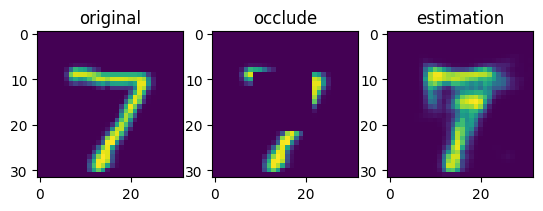

In [47]:
experiment(config, x)

In [88]:
config["estimator_params"]["mode"] = "denoise_avg"
config["estimator_params"]["denoise_step_size"] = 0.1

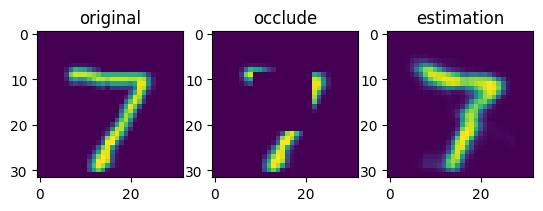

In [87]:
experiment(config, x)